In [1]:
import tune_measure as tm
import numpy as np
import matplotlib.pyplot as plt
import pyaccel as pa 
#%config Completer.use_jedi = False

# Creating or loading the Data

In [2]:
N_max = 500
KsL_list = -np.linspace(0,0.05,num=4)
coupling_list = np.zeros([KsL_list.size])
error_naff_tune1 = coupling_list.copy()
error_naff_tune2 = coupling_list.copy()
tune1_list = coupling_list.copy()
tune2_list = coupling_list.copy()

Run the following cell to load the data

In [3]:
datax = np.load("simul_data/datax2.npy")
datay = np.load("simul_data/datay2.npy")
tune1_list = np.load('simul_data/tune1_list.npy')
tune2_list = np.load('simul_data/tune2_list.npy')

Or run the below cell to create the data

In [19]:
datax = np.zeros([coupling_list.size, N_max, 50])
datay = datax.copy()
offset = np.array(
    [[0.5e-3],
    [0],
    [0.1e-3],
    [0],
    [0],
    [0]]
    )

for KsL_idx, KsL in enumerate(KsL_list):        
        obj = tm.BPMeasure()
    
        obj.create_booster(KsL=KsL)
        coupling_list[KsL_idx] = obj._coupling_coef
        
        tune1, tune2 = obj._eqparams.tune1, obj._eqparams.tune2
        
        tune1_list[KsL_idx], tune2_list[KsL_idx] = tune1, tune2

        # obj.create_initial_bunch(n_part=1000, offset=offset)
        # x_m, y_m = obj.tracking_and_get_bpmdata(N_turns=N_max)
        # datax[KsL_idx] = x_m
        # datay[KsL_idx] = y_m
        
        print("step", KsL_idx, "done")

step 0 done
step 1 done
step 2 done
step 3 done


In [20]:
np.save("simul_data/datax2", datax)
np.save("simul_data/datay2", datay)
np.save("simul_data/tune1_list", tune1_list)
np.save("simul_data/tune2_list", tune2_list)
np.save("simul_data/coupling_list", coupling_list)

# Error analysis: Mixed BPM Data + Fourier Transform

In [21]:
N_list = np.arange(19,N_max,18)
f_tune1_matrix = np.zeros([coupling_list.size, N_list.size]) 
f_tune2_matrix = f_tune1_matrix.copy()

# Computes the error associated with a given N and coupling
for N_index, N in enumerate(N_list):
    for C_index, C in enumerate(coupling_list):
        # Gets the data referent to C_index system
        x_m, y_m = datax[C_index], datay[C_index]
        
        # Uses only the N first revolutions to calc tunes
        f_tune1, f_tune2 = tm.tune_by_DFT2(x_m[:N,:], y_m[:N,:])
        
        # Passes the tunes to the matrices
        f_tune1_matrix[C_index][N_index] = np.abs(f_tune1)
        f_tune2_matrix[C_index][N_index] = np.abs(f_tune2)

/home/facs/repos/apsuite/apsuite/emittance_exchange/bo_tune_measure/tune_measure.py:141: RuntimeWarning: invalid value encountered in true_divide
  yf_normalized = yf/(yf.max() - yf.min())


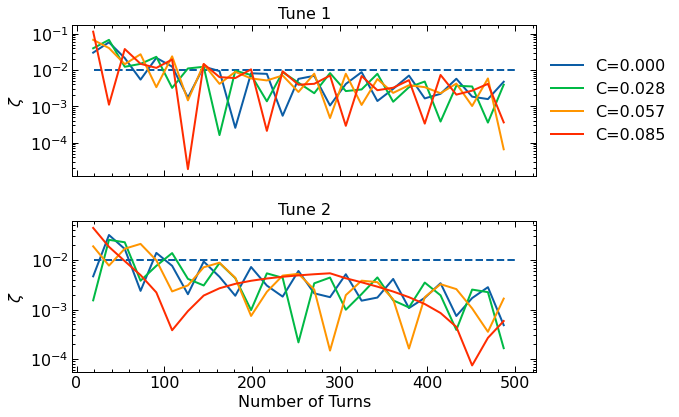

In [28]:
error1 = np.abs(f_tune1_matrix - tune1_list[:, None])
error2 = np.abs(f_tune2_matrix - tune2_list[:, None])
# Computes relative error
rel_error1_matrix = error1/tune1_list[:, None]
rel_error2_matrix = error2/tune2_list[:, None]

with plt.style.context(['science', 'notebook']):
    fig, ax = plt.subplots(2,1, sharex=True)
    fig.tight_layout(pad=3.0)
    #fig.set_dpi(160)
    for c_idx, c in enumerate(coupling_list):
        ax[0].semilogy(N_list, rel_error1_matrix[c_idx, :], label="C={:.3f}".format(c))
        ax[1].semilogy(N_list, rel_error2_matrix[c_idx, :], label="C={:.3f}".format(c))        

    ax[0].set_title("Tune 1")
    ax[0].set_ylabel("$\zeta$") #Zeta is the relative error
    ax[0].hlines(1e-2,20,N_max, linestyles='dashed')
    ax[1].set_title("Tune 2")
    ax[1].set_ylabel("$\zeta$")
    ax[1].set_xlabel("Number of Turns")
    ax[1].hlines(1e-2,20,N_max, linestyles='dashed')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax[1].text(x=550, y=0.00001, s="\n initial amplitudes: \n $x_0 = {} \, mm$"
    #                                  "\n $x'_0 = {} \, m rad$"
    #                                  "\n $y_0 = {} \,  mm$"
    #                                  "\n $y'_0 = {} \, m rad$".format(offset[0][0]*1e3, offset[1][0]*1e3, offset[2][0]*1e3, offset[3][0]*1e3), fontsize = 15)

# Error analysis: Mixed BPM Data + NAFF

In [4]:
N_list = np.arange(19,N_max,18)
naff_tune1_matrix = np.zeros([coupling_list.size, N_list.size]) 
naff_tune2_matrix = naff_tune1_matrix.copy()

# Computes the error associated with a given N and coupling
for N_index, N in enumerate(N_list):
    for C_index, C in enumerate(coupling_list):
        # Gets the data referent to C_index system
        x_m, y_m = datax[C_index], datay[C_index]
        
        # Uses only the N first revolutions to calc tunes
        naff_tune1, naff_tune2 = tm.tune_by_NAFF(x_m[:N,:], y_m[:N,:])
        
        # Passes the tunes to the matrices
        naff_tune1_matrix[C_index][N_index] = np.abs(naff_tune1)
        naff_tune2_matrix[C_index][N_index] = np.abs(naff_tune2)

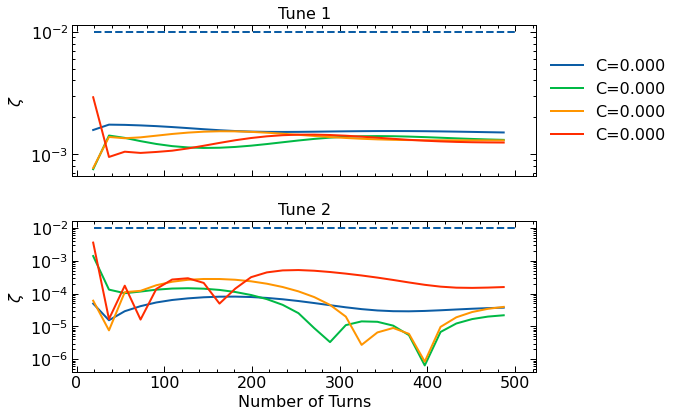

In [5]:
error1 = np.abs(naff_tune1_matrix - tune1_list[:, None])
error2 = np.abs(naff_tune2_matrix - tune2_list[:, None])
# Computes relative error
rel_error1_matrix = error1/tune1_list[:, None]
rel_error2_matrix = error2/tune2_list[:, None]

#rel_error1_matrix = error1
#rel_error2_matrix = error2

with plt.style.context(['science', 'notebook']):
    fig, ax = plt.subplots(2,1, sharex=True)
    fig.tight_layout(pad=3.0)
    #fig.set_dpi(160)
    for c_idx, c in enumerate(coupling_list):
        ax[0].semilogy(N_list, rel_error1_matrix[c_idx, :], label="C={:.3f}".format(c))
        ax[1].semilogy(N_list, rel_error2_matrix[c_idx, :], label="C={:.3f}".format(c))        

    ax[0].set_title("Tune 1")
    ax[0].set_ylabel("$\zeta$") #Zeta is the relative error
    ax[0].hlines(1e-2,20,N_max, linestyles='dashed')
    ax[1].set_title("Tune 2")
    ax[1].set_ylabel("$\zeta$")
    ax[1].set_xlabel("Number of Turns")
    ax[1].hlines(1e-2,20,N_max, linestyles='dashed')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax[1].text(x=550, y=0.00001, s="\n initial amplitudes: \n $x_0 = {} \, mm$"
    #                                  "\n $x'_0 = {} \, m rad$"
    #                                  "\n $y_0 = {} \,  mm$"
    #                                  "\n $y'_0 = {} \, m rad$".format(offset[0][0]*1e3, offset[1][0]*1e3, offset[2][0]*1e3, offset[3][0]*1e3), fontsize = 15)

# Tune Heatmap Tests

## Idea 1: Mixed BPM Data and Fourier Transform

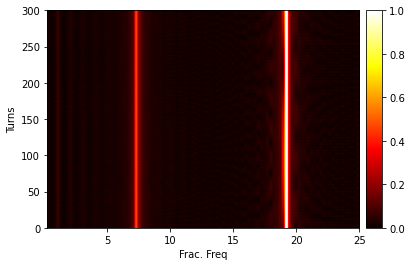

In [4]:
x_m, y_m = datax[0], datay[0]
freqs, spc1, spc2 = tm.spectrogram_mixed(x_m, y_m, dn=200)

As the window of frequency in the mixed bpm data method retains the fully possible tune values, not only the decimal part, the resolution of this method is highly limited by  low dn or by high $M$, despite high $M$ provides more acuraccy.

The separation between frequencies is $d = \frac{M}{dN}$

I this case, $d = 50/200 = 0.25$

In [ ]:
np.diff(freqs).unique()

## Idea 2: Mean of the single BPM spectrums 

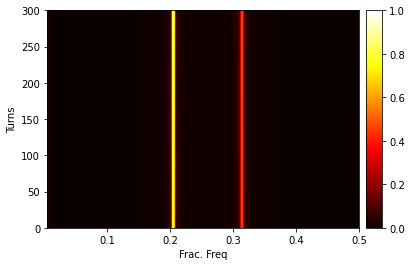

In [9]:
x_m, y_m = datax[0], datay[0]
freqs, espc1, espc2 = tm.spectrogram_mean(x_m, y_m, 200)

## Idea 3: NAFF and nearest neighbor frequencies

# Measuring Tunes during emmitance exchange 

In [2]:
obj = tm.BPMeasure()
obj.create_booster(rad=True, KsL = -0.02)
print("C=", obj._coupling_coef)
offset = np.array(
    [[0.5e-3],
    [0],
    [0.1e-3],
    [0],
    [0],
    [0]]
    )
obj.create_initial_bunch(n_part=1000,offset=offset)
x_m, y_m, tunes = obj.tracking_and_get_bpmdata(N_turns=2000, KL_crossing=0.189, out_tunes=True)

C= 0.03380237731216222


In [3]:
np.save("simul_data/x_m_exch", x_m)
np.save("simul_data/y_m_exch", y_m)
np.save("simul_data/tunes_exch", tunes)

In [9]:
x_m = np.load("simul_data/x_m_exch.npy")
y_m = np.load("simul_data/y_m_exch.npy")
#tunes = np.load("simul_data/tunes_exch")

In [14]:
N_list = np.arange(1,2000,100)[:-1]
#N_list = np.arange(0,2000)
tune1, tune2 = tm.NAFF_tune_evolution(x_m, y_m, dn=100)

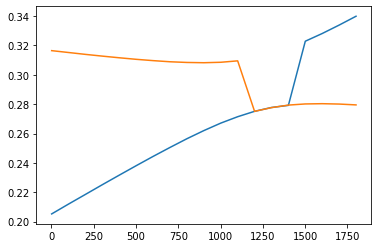

In [15]:
plt.plot(N_list, tune1)
plt.plot(N_list, tune2)

# Squematic graphs 

Text(0, 0.5, '$\\epsilon$ [nm]')

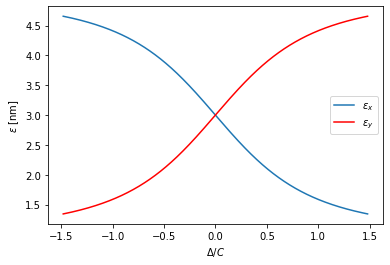

In [5]:
C = 0.0338
delta1 = np.linspace(-0.05,0,num=600)
delta2 = np.linspace(0,0.05,num=600)

delta = np.concatenate([delta1,delta2])
emitx0 = 5
emity0 = 1

emitx1 = emitx0 + C**2/(delta1**2 + C**2 + np.abs(delta1)*np.sqrt(delta1**2 + C**2)) * (emity0 - emitx0)/2
emitx2 = emitx0 + C**2/(delta2**2 + C**2 - np.abs(delta2)*np.sqrt(delta2**2 + C**2)) * (emity0 - emitx0)/2

emitx = np.concatenate([emitx1, emitx2])

emity1 = emity0 - C**2/(delta1**2 + C**2 + np.abs(delta1)*np.sqrt(delta1**2 + C**2)) * (emity0 - emitx0)/2
emity2 = emity0 - C**2/(delta2**2 + C**2 - np.abs(delta2)*np.sqrt(delta2**2 + C**2)) * (emity0 - emitx0)/2

emity = np.concatenate([emity1, emity2])

plt.plot(delta/C, emitx, label="$\epsilon_x$")
plt.plot(delta/C, emity, label="$\epsilon_y$", c='r')
plt.legend(loc="best")
plt.xlabel('$\Delta/C$')
plt.ylabel("$\epsilon$ [nm]")

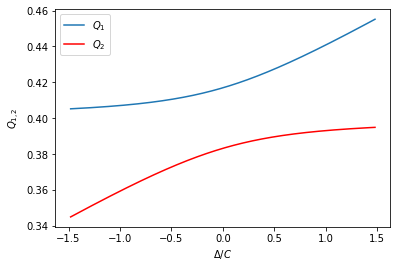

In [6]:
q2 = 0.4
q1 = q2 + delta


q1 = q1 - delta/2 + np.sqrt(delta**2 + C**2)/2
q2 = q2 + delta/2 - np.sqrt(delta**2 + C**2)/2
plt.plot(delta/C, q1, label ="$Q_1$")
plt.plot(delta/C, q2, label = "$Q_2$", c='r')
plt.xlabel('$\Delta/C$')
plt.ylabel("$Q_{1,2}$")
plt.legend()

In [13]:
T = 10*np.pi # Space length
N = 10 # Number of points
t = np.linspace(0,T,num=N)
f = 0.4 # frequency
f2 = 1.6
y1 = np.sin(2*np.pi*f*t) # Signal
y2 = np.sin(2*np.pi*f2*t)
y = y1 + y2
s_r = N/T # Sample rate

freqs, fourier = pa.naff.naff_general(y, nr_ff=3, is_real=True, window=1)

In [14]:
freqs*s_r, fourier

(array([-0.07957747,  0.        ,  0.        ]),
 array([3.991518e-317+0.j, 0.000000e+000+0.j, 0.000000e+000+0.j]))

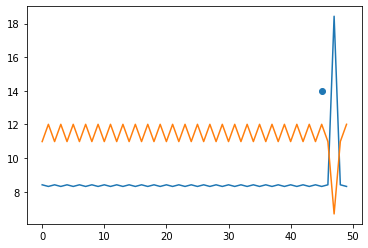

In [12]:
bo = pm.bo.create_accelerator(energy=3e9)
famdata = pm.bo.get_family_data(bo)
bpm_idx = famdata["BPM"]['index']
et, _ = pa.optics.calc_edwards_teng(bo)
betax = et.beta1[bpm_idx]
betay = et.beta2[bpm_idx]
idx = np.arange(len(bpm_idx))
plt.plot(idx, betax)
plt.plot(idx, betay)
plt.scatter(45,14)